# Create continuous surface temperature record

We use the Met-City Tower site as the main source for surface temperature.  However, the record has missing data.  To fill these missing data we use surface temperature from the auxilliary sites; ASFS30, ASFS40 and ASFS50.

In [1]:
from pathlib import Path
import warnings
import datetime as dt

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import hvplot.xarray
import pyproj
import pandas as pd

from mosaic_underice_sunlight.filepath import VIRTUAL_ZARR_JSONS
from mosaic_underice_sunlight.data.mosaic_met_kerchunker import load_metdata_zarr
from mosaic_underice_sunlight.data.get_metdata_for_transects import get_met_data_for_one_transect, extract_to_dataframe

SITE_NAMES = ["tower","asfs30","asfs40","asfs50"]

from read_kerchunked_helpers import get_midday_location, get_valid_obs, sample_by_time, find_missing_periods

/home/apbarret/mambaforge/envs/mosaic_underice_sunlight/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

I created virtual zarr files for the data to speed up loading.

In [2]:
%%time
tower = load_metdata_zarr(VIRTUAL_ZARR_JSONS['tower'])
asfs30 = load_metdata_zarr(VIRTUAL_ZARR_JSONS['asfs30'])
asfs40 = load_metdata_zarr(VIRTUAL_ZARR_JSONS['asfs40'])
asfs50 = load_metdata_zarr(VIRTUAL_ZARR_JSONS['asfs50'])

CPU times: user 423 ms, sys: 69.5 ms, total: 492 ms
Wall time: 6.03 s


In [3]:
# tower has geographic coordinates lon_tower and lat_tower.  Change these to lon and lat for 
# convenience
tower = tower.rename_vars(
    {
        "lon_tower": "lon",
        "lon_tower_qc": "lon_qc",
        "lat_tower": "lat",
        "lat_tower_qc": "lat_qc",
    }
)

## Plot path of met towers

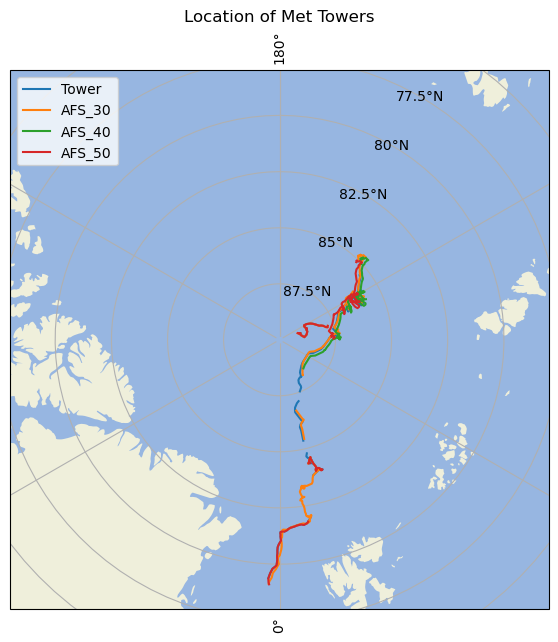

In [4]:
proj = ccrs.NorthPolarStereo()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection=proj)
    ax.set_extent([-180., 180., 78., 90.], ccrs.PlateCarree())

    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND)

    ax.gridlines(draw_labels=True)

    ax.plot(
        *get_midday_location(tower, longitude="lon", latitude="lat"), 
        transform=ccrs.PlateCarree(), label="Tower",
    )

    ax.plot(
        *get_midday_location(asfs30, longitude="lon", latitude="lat"), 
        transform=ccrs.PlateCarree(), label="AFS_30",
    )

    ax.plot(
        *get_midday_location(asfs40, longitude="lon", latitude="lat"), 
        transform=ccrs.PlateCarree(), label="AFS_40",
    )

    ax.plot(
        *get_midday_location(asfs50, longitude="lon", latitude="lat"), 
        transform=ccrs.PlateCarree(), label="AFS_50",
    )

    ax.legend(loc="upper left")

    ax.set_title("Location of Met Towers")

## Plot time series of Skin Temperature

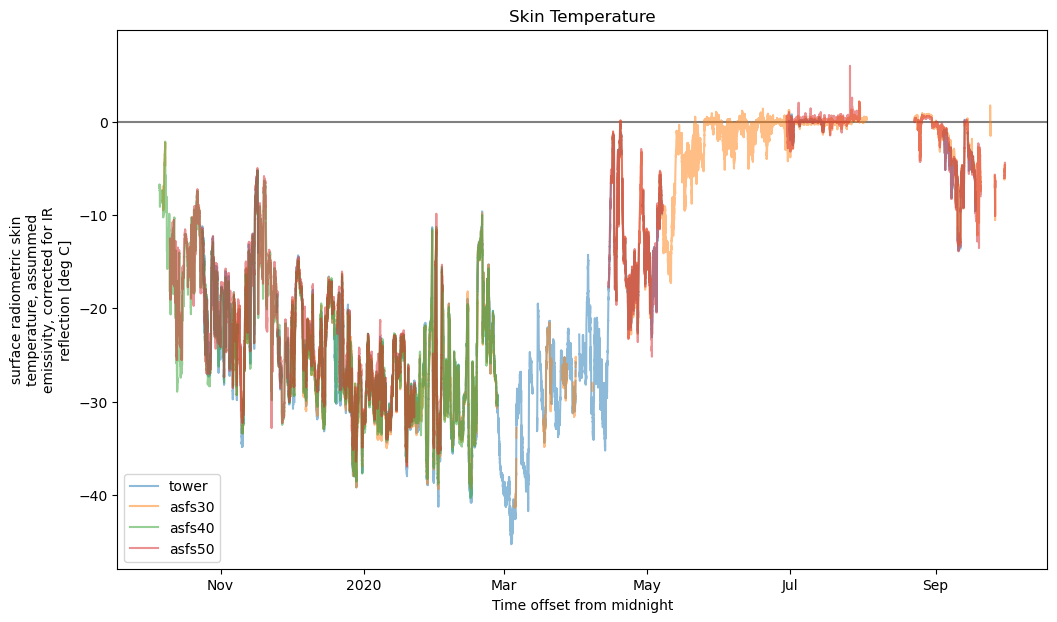

In [5]:
fig, ax = plt.subplots(figsize=(12,7))
tower.skin_temp_surface.plot(ax=ax, label='tower', alpha=0.5)
asfs30.skin_temp_surface.plot(ax=ax, label='asfs30', alpha=0.5)
asfs40.skin_temp_surface.plot(ax=ax, label='asfs40', alpha=0.5)
asfs50.skin_temp_surface.plot(ax=ax, label='asfs50', alpha=0.5)
ax.axhline(0, c="0.5", zorder=0)
ax.set_title("Skin Temperature")
ax.legend()

We can see a number of issues.  First there is at least one period where there is no data.  This was because the entire campaign relocated between legs 5 and 6.  Another issue is that surface temperatures are greater than $0\, \mathrm{^{\circ}C}$.  This shouldn't happen over a melting surface, where temperature should be at $0\, \mathrm{^{\circ}C}$.

# Find which stations are closest to the Tower site

I want to use the auxilliary stations closest to Tower to fill missing data.

In [6]:
def extract_midday_loc(ds):
    return ds[["lon", "lat"]].to_dataframe().resample("24h", offset="12h").first()

sites = SITE_NAMES
datasets = [tower, asfs30, asfs40, asfs50]
data = {site: extract_midday_loc(ds) for site, ds in zip(sites, datasets)}
coords = pd.concat(data, axis=1).dropna(how="all")
coords

tower          asfs30                 asfs40             \
                      lon lat         lon        lat         lon        lat   
time                                                                          
2019-10-14 12:00:00   NaN NaN  135.253811  84.681684  133.451674  84.689076   
2019-10-15 12:00:00   NaN NaN  135.098357  84.679390  133.299572  84.686857   
2019-10-16 12:00:00   NaN NaN  134.280980  84.678735  132.494243  84.685374   
2019-10-17 12:00:00   NaN NaN  133.692710  84.669557  131.929293  84.677710   
2019-10-18 12:00:00   NaN NaN  133.921378  84.730469  132.148741  84.743924   
...                   ...  ..         ...        ...         ...        ...   
2020-09-19 12:00:00   NaN NaN  110.046046  89.138931         NaN        NaN   
2020-09-23 12:00:00   NaN NaN   59.495614  86.005179         NaN        NaN   
2020-09-25 12:00:00   NaN NaN   35.559182  86.029227         NaN        NaN   
2020-09-29 12:00:00   NaN NaN    1.605971  81.725074         NaN        NaN   
2020-09-30 12:00:00   NaN NaN    1.446851  81.700973         NaN        NaN   

                         asfs50             
                            lon        lat  
time                                        
2019-10-14 12:00:00  134.370382  84.973350  
2019-10-15 12:00:00  134.239920  84.970790  
2019-10-16 12:00:00  133.576706  84.968115  
2019-10-17 12:00:00  133.064515  84.959700  
2019-10-18 12:00:00  133.289379  85.030043  
...                         ...        ...  
2020-09-19 12:00:00  110.046197  89.138786  
2020-09-23 12:00:00         NaN        NaN  
2020-09-25 12:00:00   35.568921  86.029227  
2020-09-29 12:00:00    1.614256  81.726513  
2020-09-30 12:00:00    1.441003  81.699161  

[335 rows x 8 columns]

                           lon        lat
time                                     
2020-02-15 12:00:00  79.777873  88.065148
                          lon        lat
time                                    
2020-02-15 12:00:00  82.09036  88.029247
                           lon        lat
time                                     
2020-02-15 12:00:00  77.061433  87.950491
                     lon  lat
time                         
2020-02-15 12:00:00  NaN  NaN


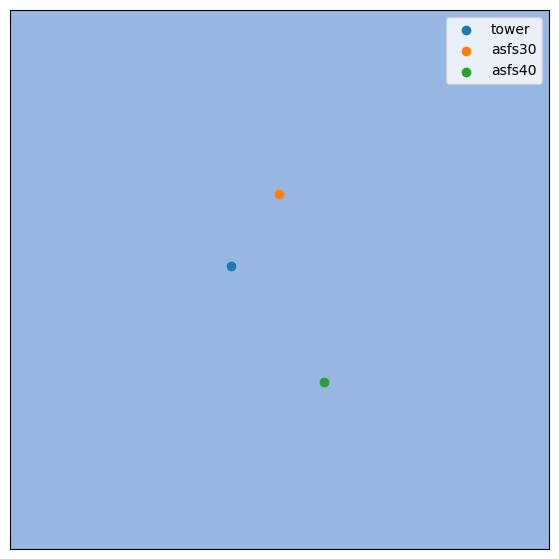

In [7]:
datestr = '2020-02-15'

max_distance = 30000.

points = coords.loc[datestr]
center_lon = points.loc[:,(slice(None),"lon")].mean(axis=1)
center_lat = points.loc[:,(slice(None),"lat")].mean(axis=1)

center_x, center_y = proj.transform_point(center_lon, center_lat, ccrs.PlateCarree())
extent = [center_x - max_distance, center_x + max_distance, 
          center_y - max_distance, center_y + max_distance]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=proj)
ax.set_extent(extent, proj)

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

#ax.gridlines(draw_labels=True)

for site in points.columns.levels[0]:
    pt = points.loc[:,(site,)]
    print(pt)
    if pt.isnull().any(axis=1).all():
        continue
    ax.scatter(pt.lon, pt.lat, transform=ccrs.Geodetic(), label=site)
ax.legend()

In [8]:
geod = pyproj.Geod(ellps="WGS84")

In [61]:
series = []
for site in coords.columns.levels[0][1:]:
    _, _, distance = geod.inv(coords["tower"].lon, coords["tower"].lat, 
                              coords[site].lon, coords[site].lat) 
    series.append(pd.Series(distance, index=coords.index, name=site))
distance_from_tower = pd.concat(series, axis=1)

<Axes: xlabel='time'>

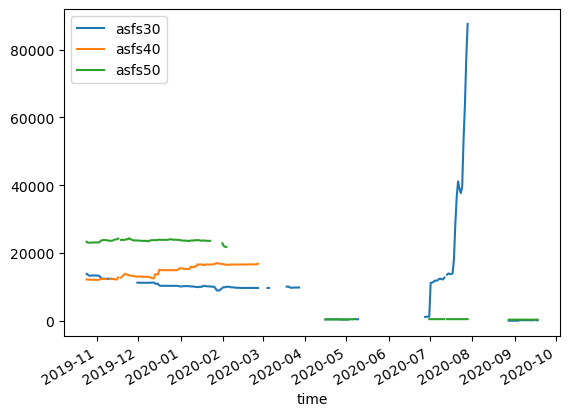

In [62]:
distance_from_tower.plot()

## Fill Tower Missing Values

The gap-filling strategy is to first fill gaps less than one day using interpolation.  I use a first order spline for this.  This reduces the gaps considerably.  Data from auxillary sites are then used to fill the remaining gaps.

It is easier to use pandas to align the data from each site and then fill.

In [10]:
time_index = pd.date_range("2019-10-05 00:00:00", "2020-10-01 23:59:59", freq="min")

sites = {}
for name, site in zip(["tower", "asfs30", "asfs40", "asfs50"], 
                      [tower, asfs30, asfs40, asfs50]):
    sites[name] = site.skin_temp_surface.to_pandas().reindex(time_index)
    
tskin_ds = pd.concat(sites, axis=1)
tskin_ds

,tower,asfs30,asfs40,asfs50
2019-10-05 00:00:00,NaN,NaN,NaN,NaN
2019-10-05 00:01:00,NaN,NaN,NaN,NaN
2019-10-05 00:02:00,NaN,NaN,NaN,NaN
2019-10-05 00:03:00,NaN,NaN,NaN,NaN
2019-10-05 00:04:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2020-10-01 23:55:00,NaN,NaN,NaN,NaN
2020-10-01 23:56:00,NaN,NaN,NaN,NaN
2020-10-01 23:57:00,NaN,NaN,NaN,NaN
2020-10-01 23:58:00,NaN,NaN,NaN,NaN


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

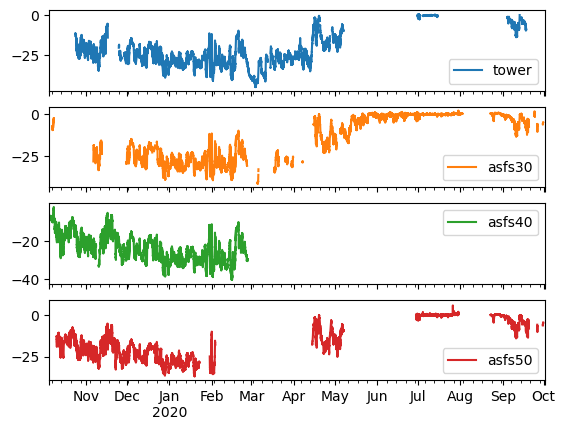

In [11]:
tskin_ds.plot(subplots=True, sharex=True)

In [12]:
tower_missing = find_missing_periods(tskin_ds.tower)
tower_missing.head()

,start,end,duration
tower,,,
1,2019-10-05 00:00:00,2019-10-24 05:29:00,27690
3,2019-10-29 00:05:00,2019-10-29 00:05:00,1
5,2019-11-16 19:01:00,2019-11-16 19:53:00,53
7,2019-11-16 23:41:00,2019-11-24 23:59:00,11539
9,2019-11-25 00:50:00,2019-11-25 04:47:00,238


<Axes: >

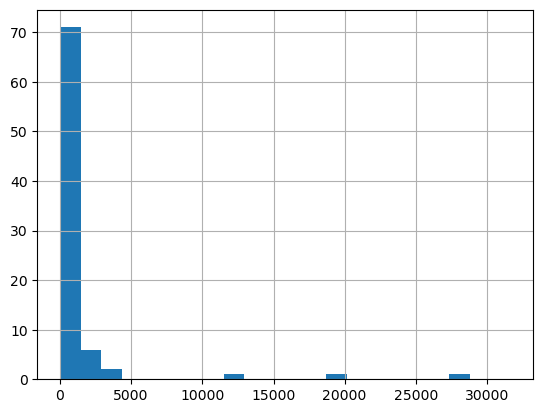

In [22]:
bins = np.arange(1, 32000, 60*24)
tower_missing.duration.hist(bins=bins)

## Investigate bias between sites

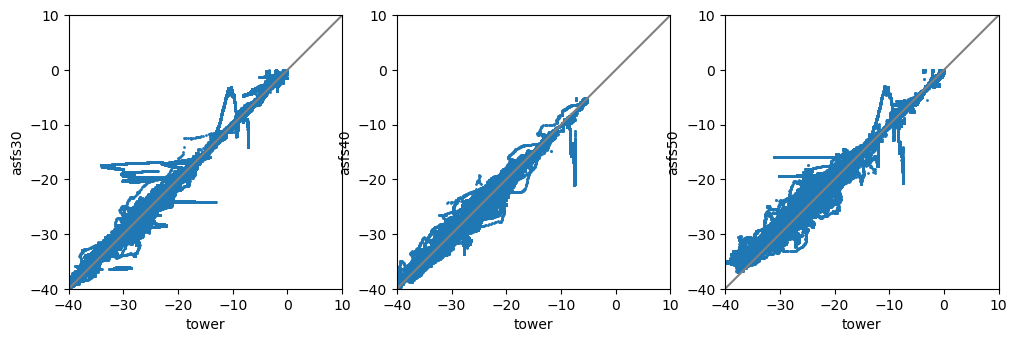

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))

tskin_ds.plot.scatter(x="tower", y="asfs30", ax=ax[0], s=1)
tskin_ds.plot.scatter(x="tower", y="asfs40", ax=ax[1], s=1)
tskin_ds.plot.scatter(x="tower", y="asfs50", ax=ax[2], s=1)
for axis in ax:
    axis.set_aspect(1)
    axis.set_xlim(-40,10)
    axis.set_ylim(-40,10)
    axis.axline((0,0), slope=1, c='0.5')

## Implement gap-filling

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

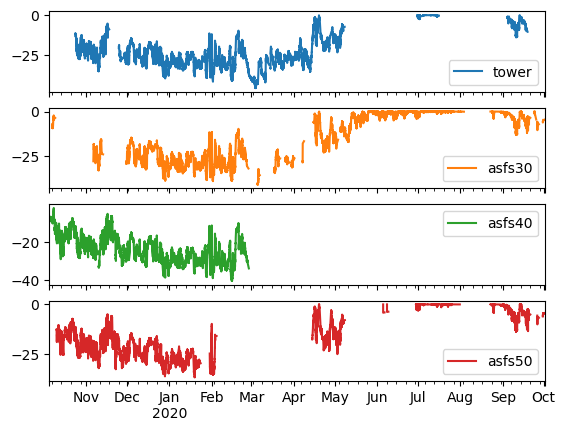

In [23]:
tskin_ds.where((tskin_ds <= 0.) | tskin_ds.isnull(), 0., inplace=True)
tskin_ds.interpolate(method="spline", order=1, limit=60*24, inplace=True)
tskin_ds.plot(subplots=True, sharex=True)

Fill gaps using auxilliary sites

In [36]:
tskin_ds["tower"] = tskin_ds["tower"].fillna(tskin_ds["asfs30"].fillna(tskin_ds["asfs40"].fillna(tskin_ds["asfs50"])))

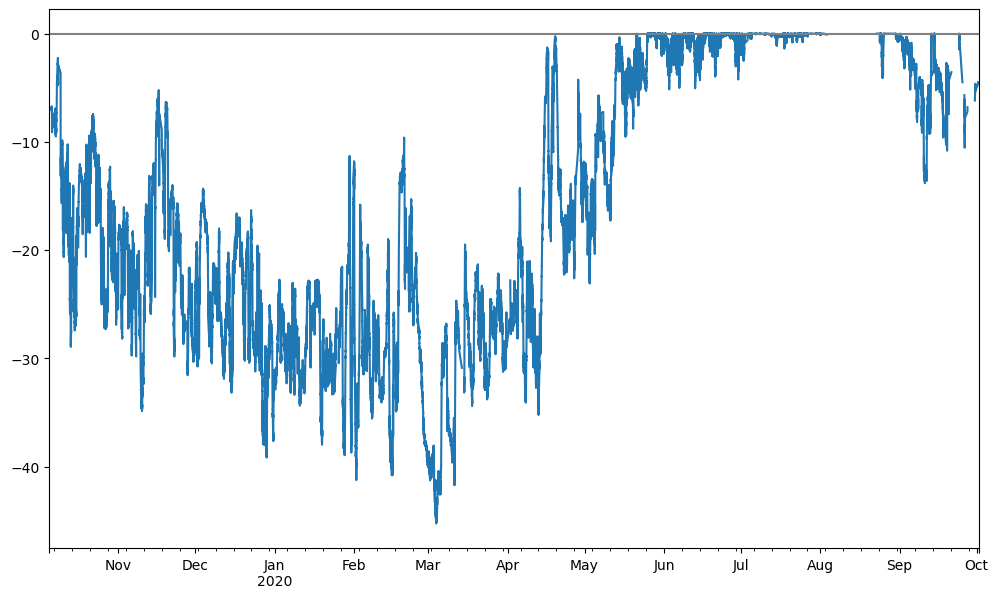

In [39]:
fig, ax = plt.subplots(figsize=(12,7))
tskin_ds["tower"].plot(ax=ax)
ax.axhline(0, c="0.5")

In [40]:
tower_filled_missing = find_missing_periods(tskin_ds["tower"])
tower_filled_missing

,start,end,duration
tower,,,
1,2019-10-05 00:00:00,2019-10-05 23:48:00,1429
3,2020-03-14 03:05:00,2020-03-14 23:59:00,1255
5,2020-04-01 13:55:00,2020-04-01 23:59:00,605
7,2020-08-03 14:15:00,2020-08-22 23:57:00,27943
9,2020-09-21 04:50:00,2020-09-24 06:04:00,4395
11,2020-09-25 11:40:00,2020-09-26 06:00:00,1101
13,2020-09-27 11:06:00,2020-09-30 08:29:00,4164
15,2020-10-01 14:10:00,2020-10-01 23:59:00,590


## Save gap-filled data

In [41]:
tskin_ds["tower"].to_csv("mosaic_tower_tskin.filled.csv")